# COCO Captioning

En esta parte de la tarea crearemos un modelo que aprenderá a generar captions para imágenes.

In [ ]:
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

import os
import urllib
import tempfile
import time
import json
from imageio import imread
from pathlib import Path

## Carga de datos

Dado que cada imagen tiene hasta 5 captions, tenemos que almacenar las captions, las features de cada imagen y un vector que nos dice a qué imagen corresponde cada caption.

In [ ]:
if not Path("coco_data.npz").is_file():
    !gdown "https://drive.google.com/uc?id=1dBlKvHUo4NAkKYy8mnrHghiIb2_c5Igl&export=download"

In [ ]:
data = np.load("coco_data.npz")
idx_to_word = data["idx_to_word"].tolist()

In [ ]:
class CaptioningDataset(torch.utils.data.Dataset):
    def __init__(self, captions, image_features, image_idxs):
        super().__init__()
        self.captions = torch.from_numpy(captions).long()
        self.image_features = torch.from_numpy(image_features)
        self.image_idxs = torch.from_numpy(image_idxs)

    def __len__(self):
        return self.captions.shape[0]

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_idx = self.image_idxs[idx]
        image_features = self.image_features[image_idx]

        return caption, image_features, image_idx

In [ ]:
train_size = 20000
val_size = 5000
remove_unk = True

train_captions = data["train_captions"]
train_features = data["train_features"]
train_image_idxs = data["train_image_idxs"]
val_captions = data["val_captions"]
val_features = data["val_features"]
val_image_idxs = data["val_image_idxs"]
train_urls = data["train_urls"]
val_urls = data["val_urls"]

if remove_unk:
    unk_word = idx_to_word.index("<UNK>")
    train_non_unk_indices = (train_captions != unk_word).all(axis=1)
    train_captions = train_captions[train_non_unk_indices]
    train_image_idxs = train_image_idxs[train_non_unk_indices]

    val_non_unk_indices = (val_captions != unk_word).all(axis=1)
    val_captions = val_captions[val_non_unk_indices]
    val_image_idxs = val_image_idxs[val_non_unk_indices]

if train_size is not None:
    train_indices = np.random.RandomState(seed=0).choice(train_features.shape[0], size=(train_size,), replace=False)
    
    train_matching_indices = np.where(np.isin(train_image_idxs, train_indices))[0]
    train_features = train_features[train_indices]
    train_captions = train_captions[train_matching_indices]
    train_image_idxs = train_image_idxs[train_matching_indices]
    train_reverse_translate = {t: i for i, t in enumerate(train_indices)}
    train_image_idxs = np.array([train_reverse_translate[idx] for idx in train_image_idxs])
    train_urls = train_urls[train_indices]

if val_size is not None:
    val_indices = np.random.RandomState(seed=0).choice(val_features.shape[0], size=(val_size,), replace=False)
    
    val_matching_indices = np.where(np.isin(val_image_idxs, val_indices))[0]
    val_features = val_features[val_indices]
    val_captions = val_captions[val_matching_indices]
    val_image_idxs = val_image_idxs[val_matching_indices]
    val_reverse_translate = {t: i for i, t in enumerate(val_indices)}
    val_image_idxs = np.array([val_reverse_translate[idx] for idx in val_image_idxs])
    val_urls = val_urls[val_indices]

train_dataset = CaptioningDataset(train_captions, train_features, train_image_idxs)
val_dataset = CaptioningDataset(val_captions, val_features, val_image_idxs)

In [ ]:
print(train_features.shape)
print(train_captions.shape)
print(train_image_idxs.shape)

print(val_features.shape)
print(val_captions.shape)
print(val_image_idxs.shape)

## Modelo

El modelo a utilizar corresponde a un modelo recurrente.

Para incluir la información de la imagen que estamos procesando, creamos una capa lineal que transforma el vector de características de la imagen en un vector de tamaño `hidd_size`. Este vector se lo entregaremos a la red recurrente como el estado escondido inicial, el cual por defecto se inicializa en cero si no se especifica.

Los captions se entregarán como entrada a la red recurrente, sin embargo, dado que los captions están compuestos por palabras, entonces primero tenemos que transformarlos a algo que la red pueda entender. Para esto se define un vocabulario fijo de 1004 palabras y se asigna a cada palabra un índice, luego se utiliza una capa de embedding. Esta capa transforma un índice en un vector entrenable. La idea es transformar palabras en vectores entrenados por la red, de modo que la red pueda generar sus propias representaciones de qué es cada palabra.

Finalmente los vectores de cada palabra se le entregan a una red LSTM siguiendo el orden de la secuencia del caption.

In [ ]:
class CaptioningModel(nn.Module):
    def __init__(self, hidd_size=128, vocab_size=1004, wordvec_dim=128):
        super().__init__()

        self.feature_net = nn.Linear(512, hidd_size)

        self.embedding_layer = nn.Embedding(vocab_size, wordvec_dim)

        self.rnn = nn.LSTM(wordvec_dim, hidd_size, batch_first=True, num_layers=1)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, vocab_size),
        )
    
    def forward(self, captions, features):
        initial_hidd_state = self.feature_net(features).unsqueeze(0)
        embedded_captions = self.embedding_layer(captions)
        out, (h, c) = self.rnn(embedded_captions, (initial_hidd_state, torch.zeros_like(initial_hidd_state)))
            
        return self.net(out)

# Training

Para el entrenamiento queremos que a partir de una imagen podamos obtener el caption correcto. Para esto muestreamos captions y features de imágenes y se los entregamos a la red recurrente con la siguiente tarea:

Se separa el caption en dos partes, la primera corresponde a todos los elementos desde el primero hasta el penúltimo, esta parte se entrega como entrada a la red recurrente. La segunda parte corresponde a todos los elementos desde el segundo hasta el último y esto es lo que se quiere predecir, es decir, estamos realizando una tarea de predecir la siguiente palabra dada la anterior. Claramente cuando evaluemos esto con una imagen que no hemos visto anteriormente no tendremos la secuencia completa por lo que puede verse como trampa utilizar las palabras futuras, pero esto se hace sólo en entrenamiento, que es donde efectivamente tenemos el caption completo.

Luego, cuando queramos generar frases, lo que se hará es entregarle a la red recurrente las features de la imagen que queremos subtitular y le entregaremos iterativamente una palabra a la vez. La primera palabra que se le entrega es un token que define el inicio de la oración y está presente en todos los ejemplos con los que entrenamos. A partir de este token y el estado oculto inicial entregado por nosotros a partir de las features de la imagen de entrada, la red recurrente generará una palabra a la salida. Luego, entregaremos esta salida de vuelta a la red junto con los nuevos estados ocultos y de esta forma iterativa se generará una oración hasta obtener el token que indica el fin de la oración.

En entrenamiento se compara la salida con lo que queremos obtener, se aplica una softmax y una loss de entropía cruzada para cada salida, promediando finalmente las losses:

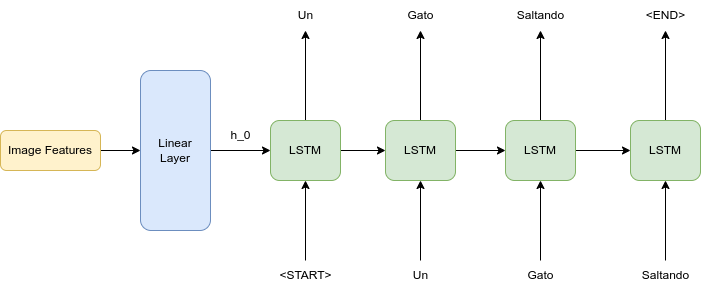

En generación de captions para una nueva imagen se ingresa el token <START> y el estado oculto relacionado a la imagen que queremos subtitular y se va generando de a una cada palabra, entregando la palabra generada como entrada a la red en la siguiente recurrencia:

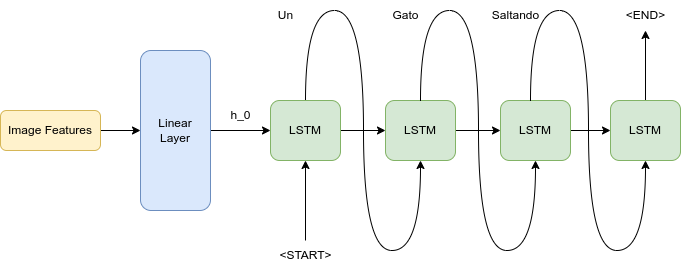

In [ ]:
def train_step(caption_batch, feature_batch, model, optimizer, criterion, use_gpu):

    in_caption = caption_batch[:, :-1]
    out_caption = caption_batch[:, 1:]

    # Predicción
    caption_predicted = model(in_caption, feature_batch)
    caption_predicted = caption_predicted.permute(0, 2, 1)

    # Cálculo de loss
    loss = criterion(caption_predicted, out_caption)
    loss = ((out_caption != 0) * loss).sum()

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return caption_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    data_count = 0

    for caption_batch, feature_batch, _ in val_loader:
        if use_gpu:
            caption_batch = caption_batch.cuda()
            feature_batch = feature_batch.cuda()

        in_caption = caption_batch[:, :-1]
        out_caption = caption_batch[:, 1:]

        # Predicción
        caption_predicted = model(in_caption, feature_batch)
        caption_predicted = caption_predicted.permute(0, 2, 1)

        # Cálculo de loss
        loss = criterion(caption_predicted, out_caption)
        loss = ((out_caption != 0) * loss).sum()
        cumulative_loss += loss.item() * caption_batch.shape[0]

        data_count += caption_batch.shape[0]

    val_loss = cumulative_loss / data_count

    return val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
):
    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    print(n_batches)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (caption_batch, feature_batch, _) in enumerate(train_loader):
            if use_gpu:
                caption_batch = caption_batch.cuda()
                feature_batch = feature_batch.cuda()

            y_predicted, loss = train_step(caption_batch, feature_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * caption_batch.shape[0]
            examples_count += feature_batch.shape[0]

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / examples_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}")

        train_loss = cumulative_train_loss / examples_count

        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    return curves

In [ ]:
lr = 5e-4
batch_size = 32
criterion = nn.CrossEntropyLoss()

epochs = 20
model = CaptioningModel()

curves = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
)

In [ ]:
def generate_sequence(model, features, deterministic=True):
    model.eval()
    hidd_state = model.feature_net(features).unsqueeze(0)
    
    start_word_idx = idx_to_word.index("<START>")
    end_word_idx = idx_to_word.index("<END>")

    current_sequence = [start_word_idx]

    c = torch.zeros_like(hidd_state)

    next_word_idx = None

    while next_word_idx != end_word_idx:
        captions = torch.tensor(current_sequence[-1])[None, None]
        embedded_captions = model.embedding_layer(captions)
        out, (hidd_state, c) = model.rnn(embedded_captions, (hidd_state, c))
        logits = model.net(out)

        if deterministic:
            next_word_idx = torch.argmax(logits)

        else:
            next_word_idx = torch.distributions.categorical.Categorical(logits=logits).sample()

        current_sequence.append(next_word_idx.item())

    return current_sequence

def translate_sequence(sequence):
    final_word_list = []
    for word_idx in sequence:
        word = idx_to_word[word_idx]
        if word == "<START>":
            continue

        if word == "<END>":
            break

        final_word_list.append(word)

    return " ".join(final_word_list)

def image_from_url(url):
    """
    Read an image from a URL. Returns a numpy array with the pixel data.
    We write the image to a temporary file then read it back. Kinda gross.
    """
    try:
        f = urllib.request.urlopen(url)
        _, fname = tempfile.mkstemp()
        with open(fname, "wb") as ff:
            ff.write(f.read())
        img = imread(fname)
        os.remove(fname)
        return img
    except urllib.error.URLError as e:
        return
        # print("URL Error: ", e.reason, url)
    except urllib.error.HTTPError as e:
        return
        # print("HTTP Error: ", e.code, url)

In [ ]:
model.cpu()

images_per_split = 2

for split in ['train', 'val']:
    if split == "train":
        dset = train_dataset
    
    else:
        dset = val_dataset

    image_features_indices = np.random.choice(dset.image_features.shape[0], size=(32,))

    captions, features, indices = next(iter(torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True)))

    i = 0
    for img_feature_idx in image_features_indices:
        if i > images_per_split:
            break

        img = image_from_url((train_urls if split == "train" else val_urls)[img_feature_idx])
        if img is None: continue

        captions_indices = np.where(dset.image_idxs == img_feature_idx)[0].tolist()
        if len(captions_indices) == 0:
            continue

        feature = dset.image_features[img_feature_idx]

        sequence = generate_sequence(model, feature.unsqueeze(0), deterministic=True)
        translated_model_sequence = translate_sequence(sequence)
        real_captions = [translate_sequence(dset.captions[c_idx].tolist()) for c_idx in captions_indices]
        real_captions = "\n".join(real_captions)

        # Skip missing URLs.
        plt.imshow(img) 
        plt.title(f"Split: {split}\nReal captions:\n{real_captions}\nPredicted caption:\n{translated_model_sequence}")
        plt.axis('off')

        i += 1

        plt.show()